In [1]:
# Import nessacary libraries

import random
import pandas as pd
import numpy as np
from scipy import stats
from plotnine import *

In [ ]:
# Import the dataset

walking_data = pd.read_excel("Walking_Data.xlsx") 
music_times = walking_data.query("Music == 'Yes'")['Time (in seconds)']
no_music_times = walking_data.query("Music == 'No'")['Time (in seconds)']
walking_data["Time (in minutes)"] = walking_data["Time (in minutes)"].dt.total_seconds() / 60
walking_data

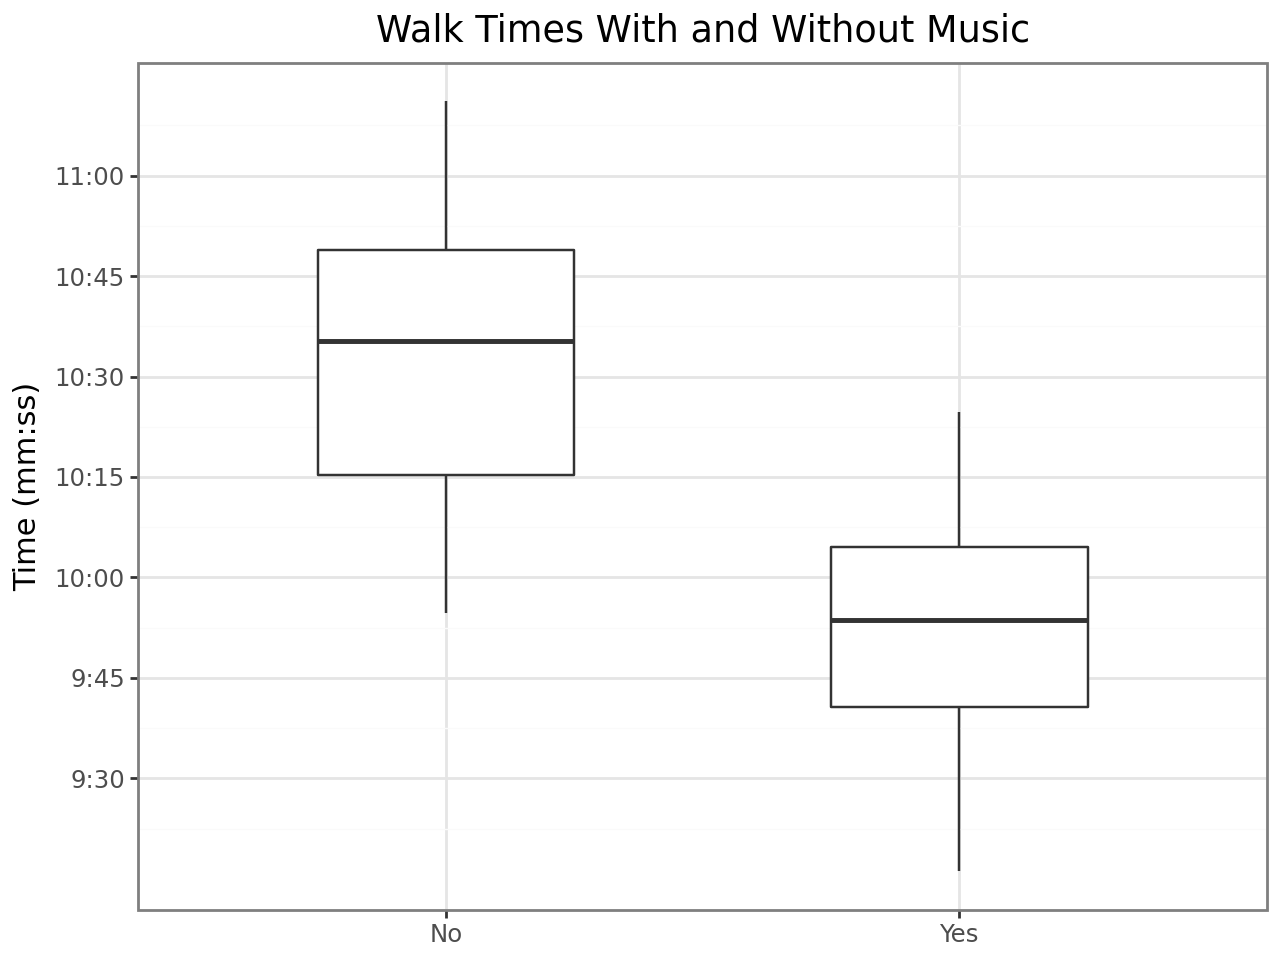

In [3]:
# Function that converts minutes as a decimal, to the mm:ss format. Example: 10.8 minutes becomes 10:48

def min_to_mmss(ticks): 

    labels = []
    for m in ticks:
        minutes = int(m)
        seconds = int(round((m - minutes) * 60))
        labels.append(f"{minutes}:{seconds:02d}")
    return labels

# Create the box and whisker plot

(
    ggplot(walking_data, aes('Music', 'Time (in minutes)'))      
    + geom_boxplot(width=0.5, outlier_alpha=0.5)
    + scale_y_continuous(
          name='Time (mm:ss)',
          labels=min_to_mmss,           
          breaks=[9.5, 9.75,10.0, 10.25, 10.5, 10.75, 11.0]  
      )
    + labs(title='Walk Times With and Without Music', x='')
    + theme_bw()
)

In [4]:
# Declare nessacary info for test stat and degrees of freedom

n_music = len(music_times)
avg_music = music_times.mean()
sd_music = music_times.std(ddof=1)
var_music = sd_music**2
n_no_music = len(no_music_times)
avg_no_music = no_music_times.mean()
sd_no_music = no_music_times.std(ddof=1)
var_no_music = sd_no_music**2

print(
    f"n music: {n_music}",
    f"avg music: {round(avg_music, 2)}",
    f"sd music: {round(sd_music, 2)}",
    f"var music: {round(var_music, 2)}",
    f"n no music: {n_no_music}",
    f"avg no music: {round(avg_no_music, 2)}",
    f"sd no music: {round(sd_no_music, 2)}",
    f"var no music: {round(var_no_music, 2)}",
    sep="\n"
)

n music: 20
avg music: 593.93
sd music: 17.6
var music: 309.77
n no music: 20
avg no music: 633.19
sd no music: 21.48
var no music: 461.2


In [5]:
# Declare our alpha, test stat, ret reg, and p-value

alpha = .01
test_stat = (avg_music - avg_no_music)/np.sqrt((var_music/n_music) + (var_no_music/n_no_music))
df = ((var_music / n_music) + (var_no_music / n_no_music))**2 \
           / ((var_music / n_music)**2 / (n_music - 1)
              + (var_no_music / n_no_music)**2 / (n_no_music - 1))
ret_reg = stats.t.ppf(alpha, df) 
pval = stats.t.cdf(test_stat, df)

print(f"Test Statistic: {round(test_stat, 2)}",
      f"Degrees of Freedom: {round(df)}",
      f"Retainment Region: [{round(ret_reg, 2)}, inf)", 
      f"P-value: {pval}",
      sep="\n")   

Test Statistic: -6.32
Degrees of Freedom: 37
Retainment Region: [-2.43, inf)
P-value: 1.1990871285973633e-07


In [6]:
# Run the test H_0: walking time with music = walking time without music

if test_stat <= ret_reg:
    print(f"Our test stat of {round(test_stat, 2)} does not fall in our retainment region of [{round(ret_reg, 2)}, inf) so we reject H_0 that I walk the same speed listening to music and not listening to music.")
else:
    print(f"Our test stat of {round(test_stat, 2)} falls in our retainment region of [{round(ret_reg, 2)}, inf) so we retain H_0 that I walk the same speed listening to music and not listening to music.")


Our test stat of -6.32 does not fall in our retainment region of [-2.43, inf) so we reject H_0 that I walk the same speed listening to music and not listening to music.


In [7]:
# p-value method for good measure

if pval <= alpha:
    print(f"Our Pvalue is {pval} which is less than our alpha of {alpha}, so we reject the null hypothesis that I walk the same speed listening to music and not listening to music.")
else:
    print(f"Our Pvalue is {pval} which is greater than our alpha of {alpha}, so we retain the null hypothesis that I walk the same speed listening to music and not listening to music.")


Our Pvalue is 1.1990871285973633e-07 which is less than our alpha of 0.01, so we reject the null hypothesis that I walk the same speed listening to music and not listening to music.


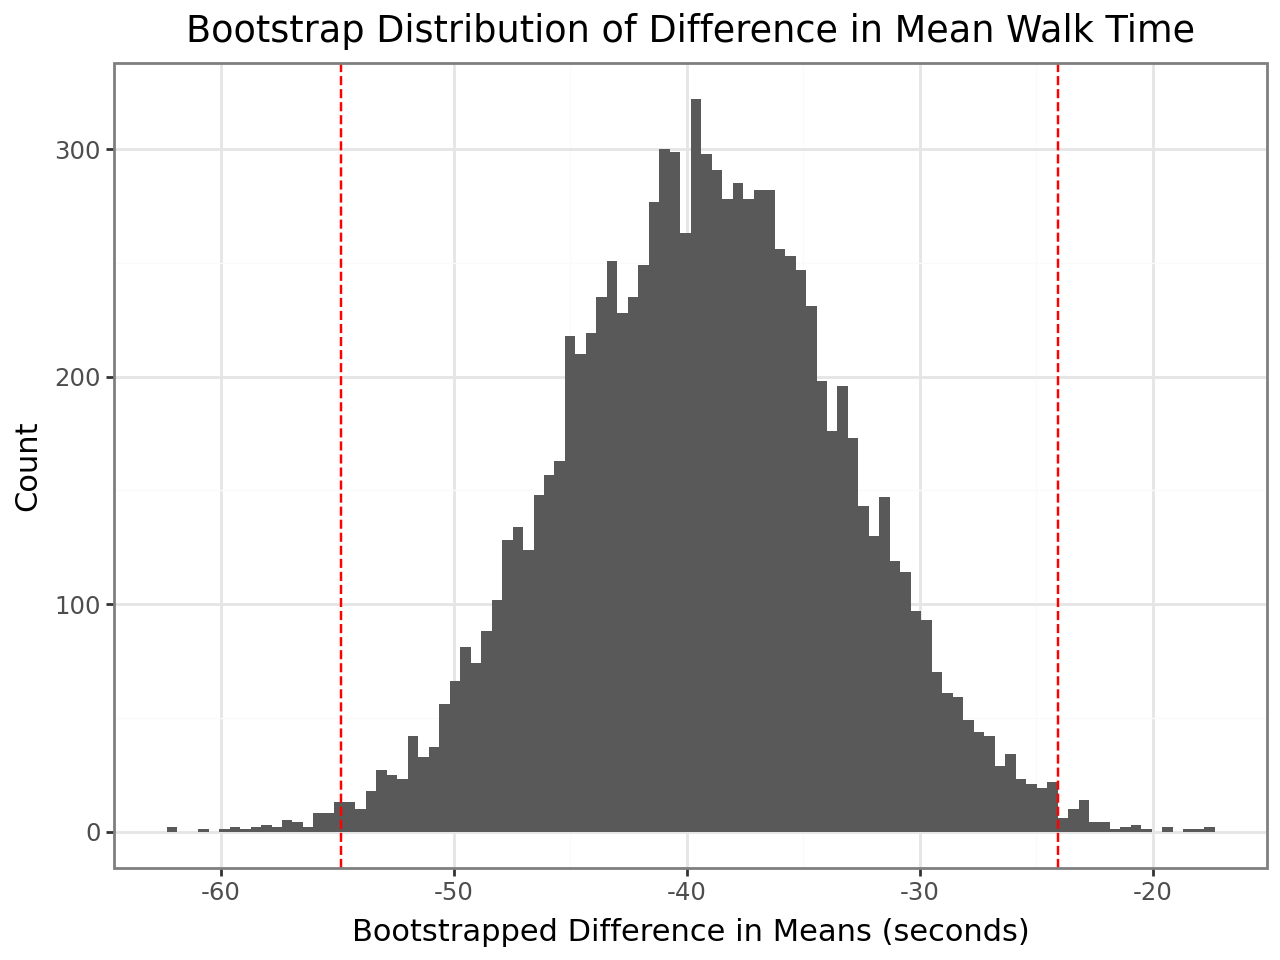

In [8]:
# Bootstrap

random.seed(7902)
B = 10_000
boot_mean_diffs = []

for b in range(B):
    avg_music_boot_samples = np.mean(np.random.choice(music_times, size = n_music, replace = True)) # Sample times from the music group
    avg_no_music_boot_samples = np.mean(np.random.choice(no_music_times, size = n_no_music, replace = True)) # Sample times from the no muisc group
    boot_mean_diffs.append(avg_music_boot_samples - avg_no_music_boot_samples) # Get 10,000 "test statistics" of avg1 - avg2 which we can collect inference from

# Get the quantiles
q_low = np.quantile(boot_mean_diffs, alpha/2)
q_high = np.quantile(boot_mean_diffs, 1-alpha/2)

df_boot = pd.DataFrame({'boot_mean_sec': boot_mean_diffs}) # Store the list with the bootstrapped mean differences as a data frame

# Plot the emperical sampling distribution 

(
    ggplot(df_boot, aes(x='boot_mean_sec')) 
    + geom_histogram(bins=100)
    + geom_vline(xintercept = q_low, linetype='dashed', color='red')
    + geom_vline(xintercept = q_high, linetype='dashed', color='red')
    + labs(
        title='Bootstrap Distribution of Difference in Mean Walk Time',
        x='Bootstrapped Difference in Means (seconds)',
        y='Count'
      )
    + theme_bw()
)
